In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

In [2]:
url = 'http://yaroslavvb.com/upload/notMNIST/'

def maybe_download(filename, expected_bytes):
    """Download a file if not present, and make sure it's the right size."""
    
    if not os.path.exists(filename):
        filename, _ = urlretrieve(url + filename, filename)
    statinfo = os.stat(filename)
    
    if statinfo.st_size == expected_bytes:
        print 'Found and verified : %s' % filename
    else:
        raise Exception(
            'Failed to verify %s Can you get to it with a browser?' % filename
        )
    
    return filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Found and verified : notMNIST_large.tar.gz
Found and verified : notMNIST_small.tar.gz


In [3]:
num_classes = 10

def extract(filename):
    
    tar = tarfile.open(filename)
    root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
    
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    sys.stdout.flush()
    tar.extractall()
    tar.close()
    
    data_folders = [
        os.path.join(root, d) for d in sorted(os.listdir(root)) if d != '.DS_Store'
    ]
  
    if len(data_folders) != num_classes:
        raise Exception(
            'Expected %d folders, one per class. Found %d instead.' % (
                num_classes, len(data_folders)
            )
        )
        
    print data_folders
    return data_folders

train_folders = extract(train_filename)
test_folders = extract(test_filename)

Extracting data for notMNIST_large. This may take a while. Please wait.
['notMNIST_large/A', 'notMNIST_large/B', 'notMNIST_large/C', 'notMNIST_large/D', 'notMNIST_large/E', 'notMNIST_large/F', 'notMNIST_large/G', 'notMNIST_large/H', 'notMNIST_large/I', 'notMNIST_large/J']
Extracting data for notMNIST_small. This may take a while. Please wait.
['notMNIST_small/A', 'notMNIST_small/B', 'notMNIST_small/C', 'notMNIST_small/D', 'notMNIST_small/E', 'notMNIST_small/F', 'notMNIST_small/G', 'notMNIST_small/H', 'notMNIST_small/I', 'notMNIST_small/J']


## Problem1
Let's take a peek at some of the data to make sure it looks sensible. Each exemplar should be an image of a character A through J rendered in a different font. Display a sample of the images that we just downloaded. Hint: you can use the package IPython.display.

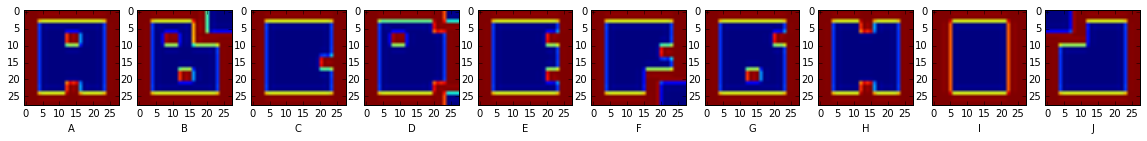

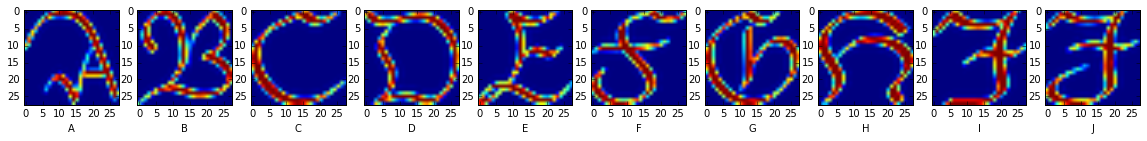

In [4]:
% matplotlib inline
import string

fig = plt.figure(figsize=(20, 10))

for ix, tf in enumerate(train_folders):
    image_path = os.path.join(tf, os.listdir(tf)[-1])
    img = Image(filename=image_path)
    fig.add_subplot(1, 10, ix+1)
    plt.imshow(plt.imread(image_path))
    plt.xlabel(string.uppercase[ix])

fig2 = plt.figure(figsize=(20, 10))    

for ix, tf in enumerate(train_folders):
    image_path = os.path.join(tf, os.listdir(tf)[-2])
    img = Image(filename=image_path)
    fig2.add_subplot(1, 10, ix+1)
    plt.imshow(plt.imread(image_path))
    plt.xlabel(string.uppercase[ix])
    

Now let's load the data in a more manageable format. Since, depending on your computer setup you might not be able to fit it all in memory, we'll load each class into a separate dataset, store them on disk and curate them independently. Later we'll merge them into a single dataset of manageable size.


We'll convert the entire dataset into a 3D array (image index, x, y) of floating point values, normalized to have approximately zero mean and standard deviation ~0.5 to make training easier down the road.


A few images might not be readable, we'll just skip them.

In [9]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
    """Load the data for a single letter label."""
    image_files = os.listdir(folder)
    dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
    image_index = 0
    print folder
  
    for image in os.listdir(folder):
        image_file = os.path.join(folder, image)
        try:
            image_data = (ndimage.imread(image_file).astype(float) -
                          pixel_depth / 2) / pixel_depth
            
            if image_data.shape != (image_size, image_size):
                raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      
            dataset[image_index, :, :] = image_data
            image_index += 1
            
        except IOError as e:
            print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
    num_images = image_index
    dataset = dataset[0:num_images, :, :]
  
    if num_images < min_num_images:
        raise Exception('Many fewer images than expected: %d < %d' % 
                        (num_images, min_num_images))
    
    print('Full dataset tensor:', dataset.shape)
    print('Mean:', np.mean(dataset))
    print('Standard deviation:', np.std(dataset))
    
    return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
    dataset_names = []
  
    for folder in data_folders:
        set_filename = folder + '.pickle'
        dataset_names.append(set_filename)
        if os.path.exists(set_filename) and not force:
            # You may override by setting force=True.
            print('%s already present - Skipping pickling.' % set_filename)
        else:
            print('Pickling %s.' % set_filename)
            dataset = load_letter(folder, min_num_images_per_class)
            try:
                with open(set_filename, 'wb') as f:
                    pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
            except Exception as e:
                print('Unable to save data to', set_filename, ':', e)

    return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

Pickling notMNIST_large/A.pickle.
notMNIST_large/A
('Could not read:', 'notMNIST_large/A/RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png', ':', IOError("cannot identify image file 'notMNIST_large/A/RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png'",), "- it's ok, skipping.")
('Could not read:', 'notMNIST_large/A/SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png', ':', IOError("cannot identify image file 'notMNIST_large/A/SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png'",), "- it's ok, skipping.")
('Could not read:', 'notMNIST_large/A/Um9tYW5hIEJvbGQucGZi.png', ':', IOError("cannot identify image file 'notMNIST_large/A/Um9tYW5hIEJvbGQucGZi.png'",), "- it's ok, skipping.")
('Full dataset tensor:', (52909, 28, 28))
('Mean:', -0.12825014)
('Standard deviation:', 0.44312069)
Pickling notMNIST_large/B.pickle.
notMNIST_large/B
('Could not read:', 'notMNIST_large/B/TmlraXNFRi1TZW1pQm9sZEl0YWxpYy5vdGY=.png', ':', IOError("cannot identify image file 'notMNIST_large/B/TmlraXNFRi1TZW1pQm9sZEl0YWxpYy5vdGY=.png'",), "- it's ok, s

In [13]:
# array of all train dataset pickle file names 
print train_datasets
print test_datasets

['notMNIST_large/A.pickle', 'notMNIST_large/B.pickle', 'notMNIST_large/C.pickle', 'notMNIST_large/D.pickle', 'notMNIST_large/E.pickle', 'notMNIST_large/F.pickle', 'notMNIST_large/G.pickle', 'notMNIST_large/H.pickle', 'notMNIST_large/I.pickle', 'notMNIST_large/J.pickle']
['notMNIST_small/A.pickle', 'notMNIST_small/B.pickle', 'notMNIST_small/C.pickle', 'notMNIST_small/D.pickle', 'notMNIST_small/E.pickle', 'notMNIST_small/F.pickle', 'notMNIST_small/G.pickle', 'notMNIST_small/H.pickle', 'notMNIST_small/I.pickle', 'notMNIST_small/J.pickle']


Merge and prune the training data as needed. Depending on your computer setup, you might not be able to fit it all in memory, and you can tune train_size as needed. The labels will be stored into a separate array of integers 0 through 9.

Also create a validation dataset for hyperparameter tuning.

In [15]:
# generate the empty ndarray by given size
def make_arrays(nb_rows, img_size):
    
    if nb_rows:
        dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
        labels = np.ndarray(nb_rows, dtype=np.int32)
    else:
        dataset, labels = None, None
    
    return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
    
    num_classes = len(pickle_files)
    valid_dataset, valid_labels = make_arrays(valid_size, image_size)
    train_dataset, train_labels = make_arrays(train_size, image_size)
    vsize_per_class = valid_size // num_classes 
    tsize_per_class = train_size // num_classes
    
    start_v, start_t = 0, 0
    end_v, end_t = vsize_per_class, tsize_per_class
    end_l = vsize_per_class + tsize_per_class
    
    for label, pickle_file in enumerate(pickle_files):
        try:
            with open(pickle_file, 'rb') as f:
                letter_set = pickle.load(f)
                # let's shuffle the letters to have random validation and training set
                np.random.shuffle(letter_set)
                
                if valid_dataset is not None:
                    valid_letter = letter_set[:vsize_per_class, :, :]
                    valid_dataset[start_v:end_v, :, :] = valid_letter
                    valid_labels[start_v:end_v] = label
                    start_v += vsize_per_class
                    end_v += vsize_per_class
                    
                train_letter = letter_set[vsize_per_class:end_l, :, :]
                train_dataset[start_t:end_t, :, :] = train_letter
                train_labels[start_t:end_t] = label
                start_t += tsize_per_class
                end_t += tsize_per_class
                
        except Exception as e:
            print('Unable to process data from', pickle_file, ':', e)
            raise

    return valid_dataset, valid_labels, train_dataset, train_labels
            
            
train_size = 200000
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

('Training:', (200000, 28, 28), (200000,))
('Validation:', (10000, 28, 28), (10000,))
('Testing:', (10000, 28, 28), (10000,))


# Problem2
Let's verify that the data still looks good. Displaying a sample of the labels and images from the ndarray. Hint: you can use matplotlib.pyplot.

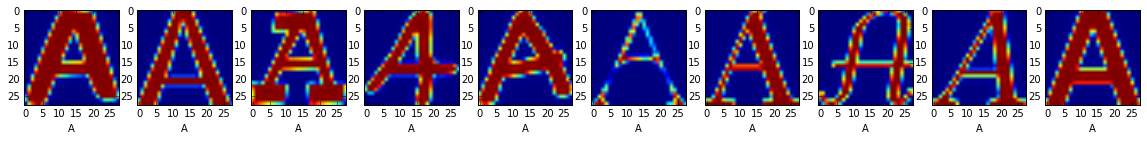

In [22]:
fig = plt.figure(figsize=(20, 10))

for i in xrange(10) :
    fig.add_subplot(1, 10, i+1)
    plt.imshow(train_dataset[i])
    plt.xlabel(string.uppercase[train_labels[i]])


# Problem 3
Another check: we expect the data to be balanced across classes. Verify that.

In [23]:
print np.bincount(train_labels)
print np.bincount(test_labels)

[20000 20000 20000 20000 20000 20000 20000 20000 20000 20000]
[1000 1000 1000 1000 1000 1000 1000 1000 1000 1000]


Next, we'll randomize the data. It's important to have the labels well shuffled for the training and test distributions

In [25]:
np.random.seed(0)
def randomize(dataset, labels):
    
    permutation = np.random.permutation(labels.shape[0])
    shuffled_dataset = dataset[permutation,:,:]
    shuffled_labels = labels[permutation]
    
    return shuffled_dataset, shuffled_labels

train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

# Problem4
Convince yourself that the data is still good after shuffling!

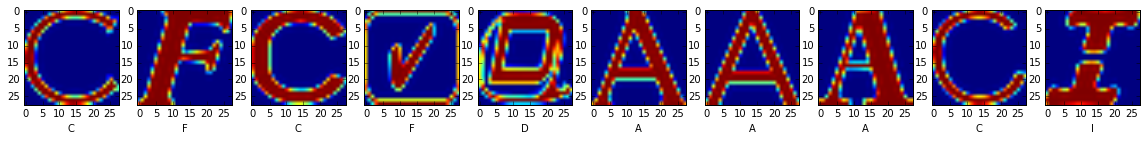

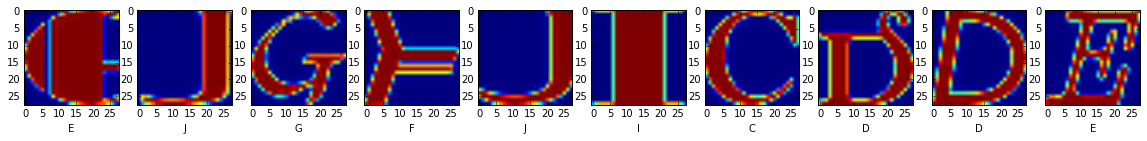

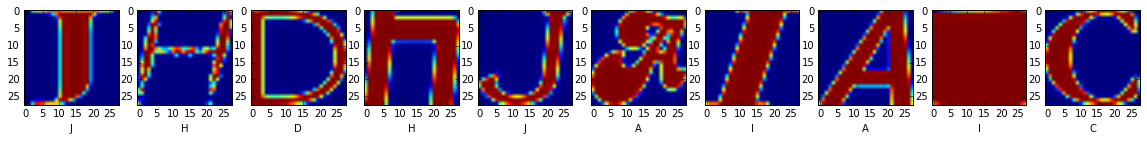

In [26]:
fig = plt.figure(figsize=(20, 10))

for i in xrange(10) :
    fig.add_subplot(1, 10, i+1)
    plt.imshow(train_dataset[i])
    plt.xlabel(string.uppercase[train_labels[i]])
    
fig2 = plt.figure(figsize=(20, 10))

for i in xrange(10) :
    fig2.add_subplot(1, 10, i+1)
    plt.imshow(test_dataset[i])
    plt.xlabel(string.uppercase[test_labels[i]])
    
fig3 = plt.figure(figsize=(20, 10))

for i in xrange(10) :
    fig3.add_subplot(1, 10, i+1)
    plt.imshow(valid_dataset[i])
    plt.xlabel(string.uppercase[valid_labels[i]])

## Finally, let's save the data for later reuse:

In [29]:
pickle_file = 'notMNIST.pickle'

try:
    f = open(pickle_file, 'wb')
    save = {
        'train_dataset': train_dataset,
        'train_labels': train_labels,
        'valid_dataset': valid_dataset,
        'valid_labels': valid_labels,
        'test_dataset': test_dataset,
        'test_labels': test_labels
    }
    
    pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
    f.close()

except Exception as e:
    print('Unable to save data to', pickle_file, ':', e)
    raise

In [30]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

('Compressed pickle size:', 690800441)


## Problem 5
By construction, this dataset might contain a lot of overlapping samples, including training data that's also contained in the validation and test set! Overlap between training and test can skew the results if you expect to use your model in an environment where there is never an overlap, but are actually ok if you expect to see training samples recur when you use it. Measure how much overlap there is between training, validation and test samples.

Optional questions:
- What about near duplicates between datasets? (images that are almost identical)
- Create a sanitized validation and test set, and compare your accuracy on those in subsequent assignments.


In [11]:
# reshape 28*28 matrix to 784*1

train_dataset_1 = np.ndarray(shape=(train_size, image_size*image_size), dtype=np.float32)
for ix, m in enumerate(sub_train_dataset):
    train_dataset_1[ix, :] = m.reshape(image_size*image_size,)
print train_dataset_1.shape


(100000, 784)


In [12]:
print sub_train_labels.shape
print sub_train_labels[0:10]

(100000,)
[0 3 1 2 2 3 2 3 3 2]


In [ ]:
"""
from scipy import stats

stats.pearsonr(train_dataset_1[0], train_dataset_1[1])

corr_dict = {}
for i in xrange(train_size-1):
    for j in xrange(i+1, train_size):
        corr_tuple = stats.pearsonr(train_dataset_1[i], train_dataset_1[j])
        if corr_tuple[0] == 1.0:
            print (i,j)
"""

In [13]:
print train_dataset_1[0], train_dataset_1[1]
print train_labels[0], train_labels[1]

[-0.5        -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
 -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
 -0.48823529 -0.5        -0.28431374  0.0254902  -0.1627451  -0.47254902
 -0.5        -0.49215686 -0.5        -0.5        -0.5        -0.5        -0.5
 -0.5        -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
 -0.5        -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
 -0.48823529 -0.5        -0.21764706  0.46078432  0.5         0.5
  0.28431374 -0.34705883 -0.5        -0.49215686 -0.5        -0.5        -0.5
 -0.5        -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
 -0.5        -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
 -0.49215686 -0.5        -0.31568629  0.44901961  0.5         0.48039216
  0.48823529  0.5         0.42156863 -0.31960785 -0.5        -0.49215686
 -0.5        -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
 -0.5        -0.5        

## Problem 6
Let's get an idea of what an off-the-shelf classifier can give you on this data. It's always good to check that there is something to learn, and that it's a problem that is not so trivial that a canned solution solves it.

Train a simple model on this data using 50, 100, 1000 and 5000 training samples. Hint: you can use the LogisticRegression model from sklearn.linear_model.

Optional question: train an off-the-shelf model on all the data!


In [15]:
from sklearn.linear_model import LogisticRegression

### First try with solver='newton-cg'

In [16]:
logreg = LogisticRegression(solver='newton-cg')
logreg.fit(train_dataset_1, sub_train_labels)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='newton-cg', tol=0.0001,
          verbose=0, warm_start=False)

In [19]:
print test_dataset.shape
test_dataset_1 =  np.ndarray(shape=(7491, image_size*image_size), dtype=np.float32)
for ix, m in enumerate(test_dataset):
    test_dataset_1[ix, :] = m.reshape(image_size*image_size,)
print test_dataset_1.shape
print test_labels.shape

(7491, 28, 28)
(7491, 784)
(7491,)


In [21]:
pred_output = logreg.predict(test_dataset_1)

In [22]:
from sklearn.metrics import accuracy_score
accuracy_score(test_labels, pred_output)

0.94927246028567613

In [25]:
logreg.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'max_iter': 100,
 'multi_class': 'ovr',
 'n_jobs': 1,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'newton-cg',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

###try with solver='lbfgs'

In [24]:
logreg2 = LogisticRegression(solver='lbfgs',n_jobs=4)
logreg2.fit(train_dataset_1, sub_train_labels)

pred_output2 = logreg2.predict(test_dataset_1)
print accuracy_score(test_labels, pred_output2)

0.949939927913


In [26]:
logreg2.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'max_iter': 100,
 'multi_class': 'ovr',
 'n_jobs': 4,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [33]:
logreg3 = LogisticRegression(C=0.5, solver='lbfgs',n_jobs=-1)
logreg3.fit(train_dataset_1, sub_train_labels)

pred_output3 = logreg3.predict(test_dataset_1)
print accuracy_score(test_labels, pred_output3)

0.949806434388


In [28]:
logreg3.get_params()

{'C': 0.5,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'max_iter': 100,
 'multi_class': 'ovr',
 'n_jobs': 4,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [32]:
print logreg3.intercept_
print logreg3.n_iter_

[-1.33968209 -2.0619984  -2.70262316 -2.07753372]
[100 100 100 100]


In [34]:
logreg4 = LogisticRegression(max_iter=200, solver='lbfgs',n_jobs=-1)
logreg4.fit(train_dataset_1, sub_train_labels)

pred_output4 = logreg4.predict(test_dataset_1)
print accuracy_score(test_labels, pred_output4)
print logreg4.intercept_
print logreg4.n_iter_

0.949539447337
[-1.35644493 -2.06403386 -2.71585575 -2.08151251]
[200 200 200 200]


In [35]:
import cPickle as pickle
loading = pickle.load(open('notMNIST.pickle'))
for key,val in loading.items():
    exec(key + '=val')

In [36]:
print train_dataset.shape
print valid_dataset.shape
print test_dataset.shape

(100000, 28, 28)
(10000, 28, 28)
(7491, 28, 28)
